In [ ]:
import warnings
warnings.filterwarnings("ignore")
import pandas as pd
import numpy as np
#import pandas_profiling
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_curve,auc, confusion_matrix
from sklearn.metrics import precision_recall_fscore_support
from sklearn.impute import KNNImputer
import seaborn as sns
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score
from sklearn.metrics import accuracy_score,f1_score
from sklearn.metrics import fbeta_score, make_scorer
from sklearn.preprocessing import MinMaxScaler
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import plot_roc_curve
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from xgboost import XGBClassifier
from sklearn.svm import SVC
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RepeatedStratifiedKFold
import xgboost as xgb
from sklearn import metrics
from sklearn.model_selection import cross_validate
from sklearn.model_selection import learning_curve, GridSearchCV
from sklearn.model_selection import cross_val_score, KFold

In [ ]:
def modelfit(alg, dtrain, predictors,useTrainCV=True, cv_folds=5, early_stopping_rounds=50):

    if useTrainCV:
        xgb_param = alg.get_xgb_params()
        xgtrain = xgb.DMatrix(dtrain[predictors].values, label=dtrain['target'].values)
        cvresult = xgb.cv(xgb_param, xgtrain, num_boost_round=alg.get_params()['n_estimators'], nfold=cv_folds,
            metrics='auc', early_stopping_rounds=early_stopping_rounds, verbose_eval = None)
        alg.set_params(n_estimators=cvresult.shape[0])

    #Fit the algorithm on the data
    alg.fit(dtrain[predictors], dtrain['target'],eval_metric='auc')

    #Predict training set:
    dtrain_predictions = alg.predict(dtrain[predictors])
    dtrain_predprob = alg.predict_proba(dtrain[predictors])[:,1]

    #Print model report:
    print("\nModel Report")
    print("Accuracy : %.4g" % metrics.accuracy_score(dtrain['target'].values, dtrain_predictions))
    print("AUC Score (Train): %f" % metrics.roc_auc_score(dtrain['target'], dtrain_predprob))

    feat_imp = pd.Series(alg.get_booster().get_fscore()).sort_values(ascending=False)
    feat_imp.plot(kind='bar', title='Feature Importances')
    plt.ylabel('Feature Importance Score')

## Encoding

In [ ]:
trainx = pd.read_csv(r"C:\Files\Jash1\IDA project\train_x.csv")
trainy = pd.read_csv(r"C:\Files\Jash1\IDA project\train_y.csv")

trainx['Loan type dup1'] = trainx['Loan type']
trainx.rename(columns = {'Loan type':'Loan_type_A'}, inplace = True)
trainx.rename(columns = {'Loan type dup1':'Loan_type_B'}, inplace = True)
trainx['Occupation type dup1'] = trainx['Occupation type']
trainx['Occupation type dup2'] = trainx['Occupation type']
trainx.rename(columns = {'Occupation type':'Occupation_type_X'}, inplace = True)
trainx.rename(columns = {'Occupation type dup1':'Occupation_type_Y'}, inplace = True)
trainx.rename(columns = {'Occupation type dup2':'Occupation_type_Z'}, inplace = True)
trainx.Loan_type_A[trainx.Loan_type_A == "A"] = 1
trainx.Loan_type_A[trainx.Loan_type_A == "B"] = 0
trainx.Loan_type_B[trainx.Loan_type_B == "B"] = 1
trainx.Loan_type_B[trainx.Loan_type_B == "A"] = 0
trainx.Occupation_type_X[trainx.Occupation_type_X == "X"] = 1
trainx.Occupation_type_X[trainx.Occupation_type_X == "Y"] = 0
trainx.Occupation_type_X[trainx.Occupation_type_X == "Z"] = 0
trainx.Occupation_type_Y[trainx.Occupation_type_Y == "X"] = 0
trainx.Occupation_type_Y[trainx.Occupation_type_Y == "Y"] = 1
trainx.Occupation_type_Y[trainx.Occupation_type_Y == "Z"] = 0
trainx.Occupation_type_Z[trainx.Occupation_type_Z == "X"] = 0
trainx.Occupation_type_Z[trainx.Occupation_type_Z == "Y"] = 0
trainx.Occupation_type_Z[trainx.Occupation_type_Z == "Z"] = 1
trainx = trainx[["ID","Expense","Income","Loan_type_A","Loan_type_B","Occupation_type_X","Occupation_type_Y","Occupation_type_Z","Age","Score1","Score2","Score3","Score4","Score5"]]

trainx = trainx.drop(columns = ['ID'])
categorical_columns = ["Loan_type_A","Loan_type_B","Occupation_type_X","Occupation_type_Y","Occupation_type_Z", 'Age']
numerical_columns = ['Expense','Income', 'Score1', 'Score2', 'Score3', 'Score4', 'Score5']

## Normalizing

In [ ]:
scaler = MinMaxScaler()
trainx.loc(axis=1)[numerical_columns] = scaler.fit_transform(trainx.loc(axis=1)[numerical_columns])
trainx = pd.DataFrame(trainx)
X_imp = trainx.copy(deep=True)
Y_imp = trainy.drop(['ID'],axis = 1)

## Imputing


In [ ]:
trainx_cont = trainx[numerical_columns]

from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
imp = IterativeImputer(random_state= 0 )
trainx_imp_cont = imp.fit_transform(trainx_cont)
trainx_imp_cont = pd.DataFrame(trainx_imp_cont)


trainx_imp_cont['Loan_type_A'] = trainx['Loan_type_A']
trainx_imp_cont['Loan_type_B'] = trainx['Loan_type_B']
trainx_imp_cont['Occupation_type_X'] = trainx['Occupation_type_X']
trainx_imp_cont['Occupation_type_Y'] = trainx['Occupation_type_Y']
trainx_imp_cont['Occupation_type_Z'] = trainx['Occupation_type_Z']
trainx_imp_cont['Age'] = trainx['Age']


In [ ]:
imputer = KNNImputer(n_neighbors = 1)
trainx_imp1 = imputer.fit_transform(trainx_imp_cont)
trainx_imp1 = pd.DataFrame(trainx_imp1)
X_imp1 = trainx_imp1.copy(deep=True)

X_imp1['y'] = Y_imp['Label']
trainxy_imp = imputer.fit_transform(X_imp1)
trainxy_imp = pd.DataFrame(trainxy_imp,columns = ['Expense','Income','Loan_type_A','Loan_type_B','Occupation_type_X','Occupation_type_Y','Occupation_type_Z','Age','Score1','Score2','Score3','Score4','Score5','y'])
y = trainxy_imp['y']
trainx_imp_final = trainxy_imp.drop(['y'],axis=1)

## Reverse Normalizing


In [ ]:
inv_train = trainx_imp_final.copy(deep=True)
inv_train.loc(axis=1)[numerical_columns] = scaler.inverse_transform(trainx_imp_final.loc(axis=1)[numerical_columns])
inv_train = pd.DataFrame(inv_train)
X = inv_train.copy(deep=True)
Y = pd.DataFrame(y)
Y.rename(columns = {'y':'Label'}, inplace = True)

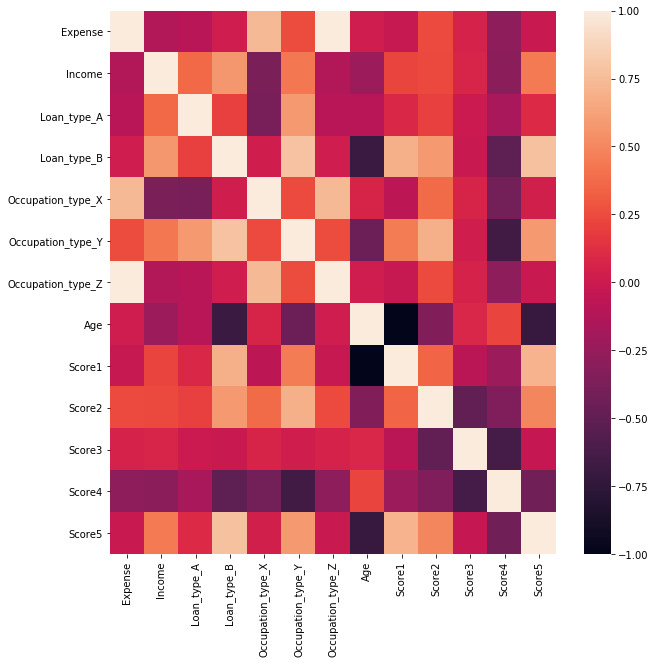

In [ ]:
fig=plt.figure(figsize=(10,10))
sns.heatmap(X.corr())

As from the correlation map above it is clear that Loan_type_B, Age, Occupation_type_Z and Score5 have high correlation due to the Dummy Variable trap and have to be dropped to increase model accuracy

## Dropping Dummyvar trap

In [ ]:
X = X.drop(columns = ['Loan_type_B','Occupation_type_Z'])
X = X.drop(columns = ['Score5'])
X = X.drop(columns = ['Age'])
XY = X.copy(deep=True)

XY['target'] = Y['Label']
train = XY.copy(deep=True)

## Fixing Learning rate and number of estimators


Model Report
Accuracy : 0.9882
AUC Score (Train): 0.995157


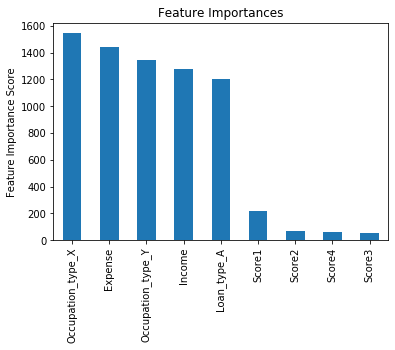

In [ ]:
predictors = [x for x in XY.columns if x not in ['target']]
xgb1 = XGBClassifier(
 learning_rate =0.1,
 n_estimators=1000,
 max_depth=5,
 min_child_weight=1,
 gamma=0,
 subsample=0.8,
 colsample_bytree=0.8,
 objective= 'binary:logistic',
 nthread=4,
 scale_pos_weight=1,
 seed=27,
 use_label_encoder = False)
modelfit(xgb1, XY, predictors)

## Tuning Max_depth and Min_child_weight

In [ ]:
param_test1 = {
 'max_depth':range(6,20,2),
 'min_child_weight':range(1,6,2)
}
gsearch1 = GridSearchCV(estimator = XGBClassifier(use_label_encoder = False,learning_rate =0.1, n_estimators=140, max_depth=5,
 min_child_weight=1, gamma=0, subsample=0.8, colsample_bytree=0.8,
 objective= 'binary:logistic', nthread=4, scale_pos_weight=1, seed=27),
 param_grid = param_test1, scoring='roc_auc',n_jobs=4,iid=False, cv=5)
gsearch1.fit(XY[predictors],XY['target'])
# gsearch1.cv_results_,
gsearch1.best_params_, gsearch1.best_score_

({'max_depth': 12, 'min_child_weight': 1}, 0.9799398704087396)

## Tune Gamma

In [ ]:
param_test3 = {
 'gamma':[i/10.0 for i in range(0,5)]
}
gsearch3 = GridSearchCV(estimator = XGBClassifier(use_label_encoder = False,learning_rate =0.1, n_estimators=140, max_depth=12,
 min_child_weight=1, gamma=0, subsample=0.8, colsample_bytree=0.8,
 objective= 'binary:logistic', nthread=4, scale_pos_weight=1,seed=27),
 param_grid = param_test3, scoring='roc_auc',n_jobs=4,iid=False, cv=5)
gsearch3.fit(XY[predictors],XY['target'])
# gsearch3.cv_results_,
gsearch3.best_params_, gsearch3.best_score_

({'gamma': 0.2}, 0.9799850287043185)

## Recalibrating the classifier


Model Report
Accuracy : 0.9928
AUC Score (Train): 0.998755


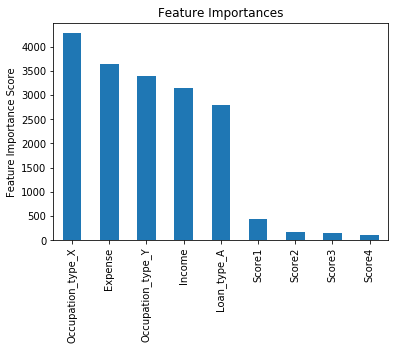

In [ ]:
xgb2 = XGBClassifier(
 learning_rate =0.1,
 n_estimators=1000,
 max_depth=12,
 min_child_weight=1,
 gamma=0.2,
 subsample=0.8,
 colsample_bytree=0.8,
 objective= 'binary:logistic',
 nthread=4,
 scale_pos_weight=1,
 seed=27,
 use_label_encoder = False)
modelfit(xgb2, XY, predictors)

## Tuning subsample and colsample_bytree

In [ ]:
param_test4 = {
 'subsample':[i/10.0 for i in range(6,10)],
 'colsample_bytree':[i/10.0 for i in range(6,10)]
}
gsearch4 = GridSearchCV(estimator = XGBClassifier(use_label_encoder = False,learning_rate =0.1, n_estimators=177, max_depth=12,
 min_child_weight=1, gamma=0.2, subsample=0.8, colsample_bytree=0.8,
 objective= 'binary:logistic', nthread=4, scale_pos_weight=1,seed=27),
 param_grid = param_test4, scoring='roc_auc',n_jobs=4,iid=False, cv=5)
gsearch4.fit(train[predictors],train['target'])
# gsearch4.cv_results_,
gsearch4.best_params_, gsearch4.best_score_


({'colsample_bytree': 0.8, 'subsample': 0.8}, 0.9801007599641508)

# Tuning reg_alpha

In [ ]:
param_test6 = {
 'reg_alpha':[1e-5, 1e-2, 0.1, 1, 100]
}
gsearch6 = GridSearchCV(estimator = XGBClassifier(use_label_encoder = False,learning_rate =0.1, n_estimators=177, max_depth=12,
 min_child_weight=1, gamma=0.2, subsample=0.8, colsample_bytree=0.8,
 objective= 'binary:logistic', nthread=4, scale_pos_weight=1,seed=27),
 param_grid = param_test6, scoring='roc_auc',n_jobs=4,iid=False, cv=5)
gsearch6.fit(train[predictors],train['target'])
# gsearch6.cv_results_,
gsearch6.best_params_, gsearch6.best_score_

({'reg_alpha': 0.1}, 0.9802083697320653)

# Tuning reg_lambda

In [ ]:
param_test8 = {
 'reg_lambda':[1e-5, 1e-2, 0.1, 1, 100]
}
gsearch8 = GridSearchCV(estimator = XGBClassifier(use_label_encoder = False,learning_rate =0.1, n_estimators=177, max_depth=12,
 min_child_weight=1, gamma=0.2, subsample=0.8, colsample_bytree=0.8,
 objective= 'binary:logistic', nthread=4, scale_pos_weight=1,seed=27,reg_alpha = 0.1),
 param_grid = param_test8, scoring='roc_auc',n_jobs=4,iid=False, cv=5)
gsearch8.fit(train[predictors],train['target'])
gsearch8.best_params_, gsearch8.best_score_

({'reg_lambda': 1}, 0.9802083697320653)

# Final Model


Model Report
Accuracy : 0.9929
AUC Score (Train): 0.998947


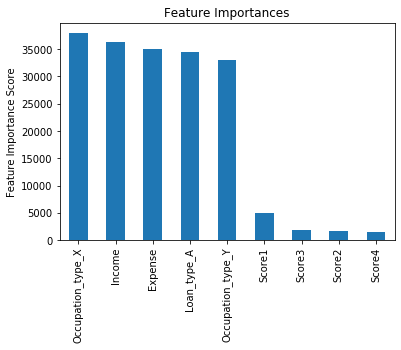

In [ ]:
xgb4 = XGBClassifier(
 learning_rate =0.01,
 n_estimators=5000,
 max_depth=12,
 min_child_weight=1,
 gamma=0.2,
 subsample=0.8,
 colsample_bytree=0.8,
 objective= 'binary:logistic',
 nthread=4,
 scale_pos_weight=1,
 reg_alpha = 0.1,
 reg_lambda = 1,
 seed=27,
 use_label_encoder = False)
modelfit(xgb4, XY, predictors)


# Train-Test split

In [ ]:
X_train,x ,Y_train, y = train_test_split(X, Y, test_size = 0.2, random_state = 42, stratify = Y)

model1 = xgb4.fit(X_train,Y_train)
y_pred_xgb4_train = model1.predict(X_train)
y_pred_xgb4_test = model1.predict(x)
f2score_test = fbeta_score(y,y_pred_xgb4_test,average ='binary',beta=2)
f2score_train = fbeta_score(Y_train,y_pred_xgb4_train,average='binary',beta=2)
acc_test = accuracy_score(y,y_pred_xgb4_test)
acc_train = accuracy_score(Y_train,y_pred_xgb4_train)

print("Training Data Set Accuracy for xgb: ", accuracy_score(Y_train,y_pred_xgb4_train))
print("Training Data F2 Score for xgb: ", f2score_train)
print("Validation Mean F2 Score for xgb: ",f2score_test)
print("Validation Mean Accuracy for xgb: ",accuracy_score(y,y_pred_xgb4_test))


Training Data Set Accuracy for xgb:  0.99325
Training Data F2 Score for xgb:  0.9244854575321287
Validation Mean F2 Score for xgb:  0.837086352065792
Validation Mean Accuracy for xgb:  0.98475


# KFold Cross Validation Score

In [ ]:
kfold = KFold(n_splits=10, shuffle=True, random_state=7)
scoresxgb = cross_val_score(model1, X, Y, cv=kfold)
accuracy_xgb= scoresxgb.mean() * (-1)
acc_xgb

-0.9845499999999999

# Importing Test Data and Preprocessing

In [ ]:
testx = pd.read_csv(r"C:\Files\Jash1\IDA project\test_x.csv")

In [ ]:
testx['Loan type dup1'] = testx['Loan type']
testx.rename(columns = {'Loan type':'Loan_type_A'}, inplace = True)
testx.rename(columns = {'Loan type dup1':'Loan_type_B'}, inplace = True)
testx['Occupation type dup1'] = testx['Occupation type']
testx['Occupation type dup2'] = testx['Occupation type']
testx.rename(columns = {'Occupation type':'Occupation_type_X'}, inplace = True)
testx.rename(columns = {'Occupation type dup1':'Occupation_type_Y'}, inplace = True)
testx.rename(columns = {'Occupation type dup2':'Occupation_type_Z'}, inplace = True)
testx.Loan_type_A[testx.Loan_type_A == "A"] = 1
testx.Loan_type_A[testx.Loan_type_A == "B"] = 0
testx.Loan_type_B[testx.Loan_type_B == "B"] = 1
testx.Loan_type_B[testx.Loan_type_B == "A"] = 0
testx.Occupation_type_X[testx.Occupation_type_X == "X"] = 1
testx.Occupation_type_X[testx.Occupation_type_X == "Y"] = 0
testx.Occupation_type_X[testx.Occupation_type_X == "Z"] = 0
testx.Occupation_type_Y[testx.Occupation_type_Y == "X"] = 0
testx.Occupation_type_Y[testx.Occupation_type_Y == "Y"] = 1
testx.Occupation_type_Y[testx.Occupation_type_Y == "Z"] = 0
testx.Occupation_type_Z[testx.Occupation_type_Z == "X"] = 0
testx.Occupation_type_Z[testx.Occupation_type_Z == "Y"] = 0
testx.Occupation_type_Z[testx.Occupation_type_Z == "Z"] = 1
testx = testx[["ID_Test","Expense","Income","Loan_type_A","Loan_type_B","Occupation_type_X","Occupation_type_Y","Occupation_type_Z","Age","Score1","Score2","Score3","Score4","Score5"]]

testx = testx.drop(columns = ['ID_Test'])
testx = testx.drop(columns = ['Loan_type_B','Occupation_type_Z'])
testx = testx.drop(columns = ['Age','Score5'])
testx['Loan_type_A'] = pd.to_numeric(testx['Loan_type_A'])
testx['Occupation_type_X'] = pd.to_numeric(testx['Occupation_type_X'])
testx['Occupation_type_Y'] = pd.to_numeric(testx['Occupation_type_Y'])

# Predicting the values

In [ ]:
model = xgb4.fit(X,Y)
y_pred_f = model.predict(testx)

y_pred_f = pd.DataFrame(y_pred_f,columns = {'Label'},index = None)
y_pred_f['ID']  = range(1,len(testx)+1)
y_pred_f = y_pred_f[["ID","Label"]]
y_pred_f.to_csv(r'C:\Files\Jash1\IDA project\pred_y.csv',index=False)